# Introduction 

Dataset shift: It occurs when the joint distribution of input and target variables differs across training and test datasets.

Covariate shift: Is the issue when the input distributions is different for train and test set. In such case, it's important to create a validation set whose performance can generalize the test set performance as well.

https://www.quora.com/In-machine-learning-what-is-dataset-shift

Adversarial validation is a technique that can be used to check whether the distributions of train and test data are different or not. It helps to find rows in our training set that are very similar to our test set, and those set of instances can be used as the validation set as that is more closer to test set distributions. In other way, while training we can give more weights to instances which are similar to test dataset.
    
**Reference https://www.kaggle.com/kevinbonnes/adversarial-validation/data**

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import gc
import datetime

from sklearn.model_selection import KFold
import lightgbm as lgb
import time
start = time.time()

# Params
NFOLD = 5

In [2]:
# Load data
train = pd.read_csv("train1.csv",nrows= 4000)
test = pd.read_csv("test1.csv",nrows = 4000)

# Mark train as 1, test as 0
train['Is_train'] = 1
test['Is_train'] = 0

# Concat dataframes
n_train = train.shape[0]
df = pd.concat([train, test], axis = 0)
del train, test
gc.collect()

28

In [3]:
# Remove columns with only one value in our training set
predictors = list(df.columns.difference(['ID', 'target','Is_train']))
df_train = df.iloc[:n_train].copy()
cols_to_remove = [c for c in predictors if df_train[c].nunique() == 1]
df.drop(cols_to_remove, axis=1, inplace=True)

# Update column names
predictors = list(df.columns.difference(['ID', 'target','Is_train']))

# Get some basic meta features
df['cols_mean'] = df[predictors].replace(0, np.NaN).mean(axis=1)
df['cols_count'] = df[predictors].replace(0, np.NaN).count(axis=1)
df['cols_sum'] = df[predictors].replace(0, np.NaN).sum(axis=1)
df['cols_std'] = df[predictors].replace(0, np.NaN).std(axis=1)

In [4]:
# Prepare for training

# Shuffle dataset
df = df.iloc[np.random.permutation(len(df))]
df.reset_index(drop = True, inplace = True)

# Get target column name
target = 'Is_train'

# lgb params
lgb_params = {
        'boosting': 'gbdt',
        'application': 'binary',
        'metric': 'auc', 
        'learning_rate': 0.1,
        'num_leaves': 32,
        'max_depth': 8,
        'bagging_fraction': 0.7,
        'bagging_freq': 5,
        'feature_fraction': 0.7,
}

# Get folds for k-fold CV
folds = KFold(n_splits = NFOLD, shuffle = True, random_state = 0)
fold = folds.split(df)
    
eval_score = 0
n_estimators = 0
eval_preds = np.zeros(df.shape[0])

In [5]:
# Run LightGBM for each fold
for i, (train_index, test_index) in enumerate(fold):
    print( "\n[{}] Fold {} of {}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), i+1, NFOLD))
    train_X, valid_X = df[predictors].values[train_index], df[predictors].values[test_index]
    train_y, valid_y = df[target].values[train_index], df[target].values[test_index]

    dtrain = lgb.Dataset(train_X, label = train_y,
                          feature_name = list(predictors)
                          )
    dvalid = lgb.Dataset(valid_X, label = valid_y,
                          feature_name = list(predictors)
                          )
        
    eval_results = {}
    
    bst = lgb.train(lgb_params, 
                         dtrain, 
                         valid_sets = [dtrain, dvalid], 
                         valid_names = ['train', 'valid'], 
                         evals_result = eval_results, 
                         num_boost_round = 5000,
                         early_stopping_rounds = 100,
                         verbose_eval = 100)
    
    print("\nRounds:", bst.best_iteration)
    print("AUC: ", eval_results['valid']['auc'][bst.best_iteration-1])

    n_estimators += bst.best_iteration
    eval_score += eval_results['valid']['auc'][bst.best_iteration-1]
   
    eval_preds[test_index] += bst.predict(valid_X, num_iteration = bst.best_iteration)
    
n_estimators = int(round(n_estimators/NFOLD,0))
eval_score = round(eval_score/NFOLD,6)

print("\nModel Report")
print("Rounds: ", n_estimators)
print("AUC: ", eval_score)    


[2019-05-29 14:28:34] Fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.96382	valid's auc: 0.904102
[200]	train's auc: 0.98603	valid's auc: 0.918199
[300]	train's auc: 0.993625	valid's auc: 0.929135
[400]	train's auc: 0.996985	valid's auc: 0.931644
Early stopping, best iteration is:
[342]	train's auc: 0.995265	valid's auc: 0.932607

Rounds: 342
AUC:  0.932607486043

[2019-05-29 14:28:53] Fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.964621	valid's auc: 0.910017
[200]	train's auc: 0.986976	valid's auc: 0.923501
[300]	train's auc: 0.993992	valid's auc: 0.926411
[400]	train's auc: 0.99743	valid's auc: 0.926359
Early stopping, best iteration is:
[339]	train's auc: 0.995811	valid's auc: 0.928215

Rounds: 339
AUC:  0.928215133478

[2019-05-29 14:29:11] Fold 3 of 5
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.964692	valid's auc: 0.880258
[200]	train's auc: 0.

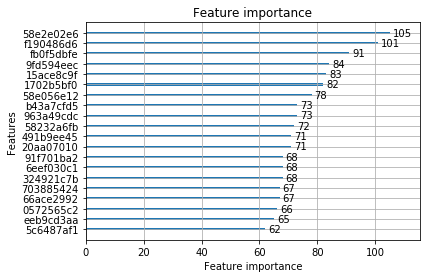

In [6]:
# Feature importance
import matplotlib.pyplot as plt
%matplotlib inline
lgb.plot_importance(bst, max_num_features = 20)


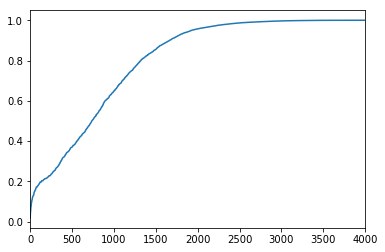

In [7]:
# Get training rows that are most similar to test
df_av = df[['ID', 'Is_train']].copy()
df_av['preds'] = eval_preds
df_av_train = df_av[df_av.Is_train == 1]
df_av_train = df_av_train.sort_values(by=['preds']).reset_index(drop=True)

# Check distribution
df_av_train.preds.plot()

# Store to feather
# df_av_train[['ID', 'preds']].reset_index(drop=True).to_feather('adversarial_validation.ft')

In [8]:
# Check first 20 rows
df_av_train.head(20)

,ID,Is_train,preds
0,519365abd,1,0.019021
1,215895e0e,1,0.035502
2,b9293856c,1,0.045303
3,abe4b4ed3,1,0.046905
4,032818895,1,0.048610
5,5dae9db78,1,0.052776
6,b59f52012,1,0.058708
7,cccbc58f9,1,0.070264
8,68b943d55,1,0.071951
9,905c792a9,1,0.076664


In [9]:
print("Total time taken:{}".format(time.time()-start))

Total time taken:110.58810663223267
